<a href="https://colab.research.google.com/github/gursoyege/lirmm-sand/blob/master/autoencoder/lirmm_sand_poke_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Verify the GPU, if not Tesla P100, maybe reset runtime and reconnect.

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jul  6 02:33:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Imports

In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

from numpy.random import default_rng, randint
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Conv2DTranspose, Reshape, LeakyReLU
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


Define image dataset and R values

In [4]:
def get_data(folder_path , act_num):
    beginning = 1
    dataFolder = sorted(glob.glob(folder_path))
    act = dataFolder[act_num]
    actionTrainFolder = sorted(glob.glob(act + "train/*/"))
    for ins_e, ins in enumerate(actionTrainFolder):
        instanceFolder = sorted(glob.glob(ins + "*/"))
        for cla_e, cla in enumerate(instanceFolder):
            classFolder = sorted(glob.glob(cla + "/*.png"))
            for img_e, img in enumerate(classFolder):
                tensor = tf.io.read_file(img)
                print(img)
                tensor = tf.io.decode_image(tensor, dtype=tf.dtypes.uint8)
                tensor = tf.image.convert_image_dtype(tensor, tf.float32)
                if beginning == 1:
                    img_w,img_h,img_d = tensor.shape
                    train_cla_n = len(instanceFolder)
                    train_img_n = len(classFolder)
                    train_set = np.zeros((len(actionTrainFolder) ,len(instanceFolder) ,len(classFolder), img_w, img_h, 1), dtype = 'float32')               
                    beginning = 0
                train_set[ins_e,cla_e,img_e,:,:,:] = tensor
    beginning = 1
    actionTestFolder = sorted(glob.glob(act + "test/*/"))
    for ins_e, ins in enumerate(actionTestFolder):
        instanceFolder = sorted(glob.glob(ins + "*/"))
        for cla_e, cla in enumerate(instanceFolder):
            classFolder = sorted(glob.glob(cla + "/*.png"))
            for img_e, img in enumerate(classFolder):
                tensor = tf.io.read_file(img)
                print(img)
                tensor = tf.io.decode_image(tensor, dtype=tf.dtypes.uint8)
                tensor = tf.image.convert_image_dtype(tensor, tf.float32)
                if beginning == 1:
                    test_cla_n = len(instanceFolder)
                    test_set = np.zeros((len(actionTestFolder) ,len(instanceFolder) ,len(classFolder), img_w, img_h, 1), dtype = 'float32')               
                    beginning = 0
                test_set[ins_e,cla_e,img_e,:,:,:] = tensor
    return img_w, img_h, train_cla_n, test_cla_n, train_img_n, train_set, test_set


def get_r_val(folder_path , act_num):
    r_all = np.array([])
    beginning = 1
    rFolder = sorted(glob.glob(folder_path))
    
    act = rFolder[act_num]
    
    actionFolder = sorted(glob.glob(act + "*/"))
    
    for ins_e, ins in enumerate(actionFolder):
        instanceFolder = sorted(glob.glob(ins + "*.npy"))
        for r_e, r in enumerate(instanceFolder):
            print(r)
            r_act = np.load(r)
            if beginning == 1:
                r_shape = r_act.shape
                r_all = np.zeros((train_cla_n + test_cla_n, r_shape[0], r_shape[1], 1))
                r_all[r_e,:,:,:] = r_act
                beginning = 0
            else :
                r_all[r_e,:,:,:] = r_act
    return r_all

Get the image dataset and R values

In [5]:
act_name = "poke"
#act_name = "tap"
lite = False

In [ ]:
if act_name == "poke":
    act_num = 0
if act_name == "tap":
    act_num = 1

img_w, img_h, train_cla_n, test_cla_n, train_img_n, train_set, test_set = get_data("/content/drive/My Drive/lirmm-sand/data/*/", act_num)

r_all = get_r_val("/content/drive/My Drive/lirmm-sand/r_value/*/", act_num)

U0 = 424
V0 = 240
FX = 417
FY = 377
r_max = np.sqrt(1 + (U0/FX)**2 + (V0/FY)**2)

Define epoch, batch, and loss

In [7]:
def make_epoch(set_complete):
    ins_e,cla_e,img_e,img_h,img_w,img_d=set_complete.shape
    cla_rand = np.zeros(cla_e)
    img_rand = np.zeros(img_e)
    rng = default_rng()
    
    cla_rand[:] = rng.choice(cla_e, size=cla_e, replace=False)
    img_rand[:] = rng.choice(img_e, size=img_e, replace=False)


    cla_rang = np.tile(cla_rand,img_e)
    img_rang = np.repeat(img_rand, cla_e)

    cla_iter = iter(cla_rang)
    img_iter = iter(img_rang)
    return cla_iter, img_iter , cla_rang, img_rang


def make_batch(set_complete, cla_iter, img_iter, batch_size):
    ins_e,cla_e,img_e,img_h,img_w,img_d=set_complete.shape
    r_batch = np.zeros((batch_size,img_h,img_w,img_d),dtype='float32')
    input_batch = np.zeros((batch_size,img_h,img_w,img_d),dtype='float32')
    ground_batch = np.zeros((batch_size,img_h,img_w,img_d),dtype='float32')
    for i in range(batch_size):
        cla_pick = next(cla_iter, None)
        img_pick = next(img_iter, None)
        if cla_pick == None or img_pick == None:
            break
        r_batch[i,:,:,:] = r_all[int(cla_pick), :,:,:]
        input_batch[i,:,:,:] = set_complete[0,int(cla_pick),int(img_pick),:,:,:]        
        ground_batch[i,:,:,:] = set_complete[1,int(cla_pick),int(img_pick),:,:,:]
    return input_batch, ground_batch, r_batch


def custom_loss(r, img_w, img_h, r_max):
    img_w = K.constant(img_w)
    img_h = K.constant(img_h)
    r_max = K.constant(r_max)
    def loss(y_true, y_pred):
        loss_value = K.sum((r * K.abs(y_pred - y_true)))/(img_w * img_h * r_max)
        return loss_value
    return loss

Create model

In [8]:
input_img = Input(shape=(img_w, img_h, 1),name='input')

x = Conv2D(32, (5, 5), padding='same', name='conv1')(input_img)
x = LeakyReLU(alpha=0.2, name='leaky1')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool1')(x)
x = Conv2D(64, (5, 5), padding='same', name='conv2')(x)
x = LeakyReLU(alpha=0.2, name='leaky2')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool2')(x)
x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
x = LeakyReLU(alpha=0.2, name='leaky3')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool3')(x)
x = Conv2D(256, (1, 1), padding='same', name='conv4')(x)
x = LeakyReLU(alpha=0.2, name='leaky4')(x)
x = MaxPooling2D((2, 2), padding='same', name='pool4')(x)

shape = x.shape
x = Flatten(name='flatten_conv2fc')(x)

x = Dense(4096, activation='relu', name='fc_encoder')(x)
x = Dense(1024, activation='relu', name='fc_latent')(x)
x = Dense(4096, activation='relu', name='fc_decoder')(x)

x = Dense(shape[1]*shape[2]*shape[3], activation='linear', name='map_fc2deconv')(x)
x = Reshape((shape[1],shape[2],shape[3]), name='reshape_fc2deconv')(x)

x = UpSampling2D((2, 2), name='unpool1')(x)
x = Conv2DTranspose(128, (1, 1), activation='relu', padding='same', name='deconv1')(x)
x = UpSampling2D((2, 2), name='unpool2')(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', name='deconv2')(x)
x = UpSampling2D((2, 2), name='unpool3')(x)
x = Conv2DTranspose(32, (5, 5), activation='relu', padding='same', name='deconv3')(x)
x = UpSampling2D((2, 2), name='unpool4')(x)
x = Conv2DTranspose(1, (5, 5), activation='relu', padding='same', name='deconv4')(x)
decoded = keras.layers.Lambda(lambda x: x[:,0:img_w,0:img_h,:], name='reshape_out')(x)

r = K.variable(np.zeros([1,img_w,img_h,1]))
autoencoder = Model(input_img, decoded, name='autoencoder')
autoencoder.summary()
autoencoder.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss=custom_loss(r,img_w,img_h,r_max))

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 52, 55, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 52, 55, 32)        832       
_________________________________________________________________
leaky1 (LeakyReLU)           (None, 52, 55, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 26, 28, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 26, 28, 64)        51264     
_________________________________________________________________
leaky2 (LeakyReLU)           (None, 26, 28, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 13, 14, 64)        

Training parameters

In [9]:
EPOCHS = 100
CLA_PASS = 1 #CLA_PASS sample from each class
batch_size = CLA_PASS * train_cla_n
step_per_epoch = int(np.ceil(train_img_n*train_cla_n/batch_size))

Train loop

In [ ]:
for epoch in range(1,EPOCHS+1):
    cla_iter, img_iter , cla_rang, img_rang = make_epoch(train_set)

    for step in range(step_per_epoch):
        input_batch, ground_batch, r_batch = make_batch(train_set, cla_iter, img_iter, batch_size)
        input_iter = iter(input_batch)
        ground_iter = iter(ground_batch)
        r_iter = iter(r_batch)

        for i in range(batch_size):
            inputs = next(input_iter)
            grounds = next(ground_iter)
            r_values = next(r_iter)

            if not np.any(inputs): # if input = all zeros
                break
            
            inputs = np.expand_dims(inputs, axis=0)
            grounds = np.expand_dims(grounds, axis=0)
            r_values = np.expand_dims(r_values, axis=0)

            r.assign(r_values)

            loss_out = autoencoder.train_on_batch(inputs, grounds)
    if epoch%1 == 0:
        print('Epoch: ', epoch, ' loss: ', loss_out)
        #autoencoder.save_weights("/content/drive/My Drive/lirmm-sand/saved_model/" + act_name + "/full/weights.h5")

Test loop

Test on trained instance of an action, never seen augmented images


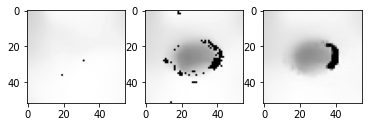

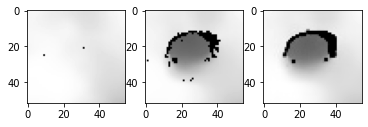

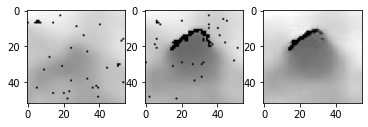

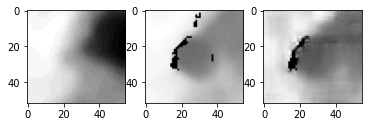

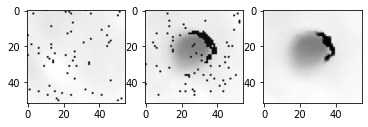

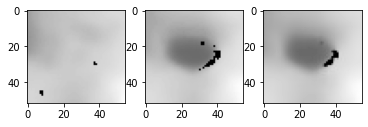

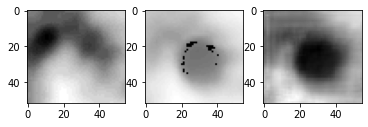

Never seen instance of an action


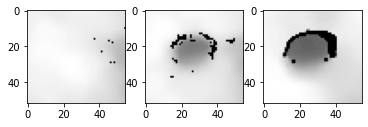

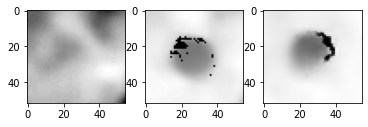

In [11]:
model_weights= sorted(glob.glob("/content/drive/My Drive/lirmm-sand/saved_model/" + act_name + "/full/*.h5"))
autoencoder.load_weights(model_weights[-1])

print('Test on trained instance of an action, never seen augmented images')
for i in range(7):
    j=0
    j += 1
    plt.subplot(1,3,j)
    imgs = test_set[0,i,:,:,:,:] 
    plt.imshow(imgs[0,:,:,0], cmap="gray")
    
    j += 1
    plt.subplot(1,3,j)
    gnds = test_set[1,i,:,:,:,:] 
    plt.imshow(gnds[0,:,:,0], cmap="gray")
    
    j += 1
    plt.subplot(1,3,j)
    decoded_imgs = autoencoder.predict(imgs)
    plt.imshow(decoded_imgs[0,:,:,0], cmap="gray")

    plt.show()
print('Never seen instance of an action')
for i in range(7,9):
    j=0
    j += 1
    plt.subplot(1,3,j)
    imgs = test_set[0,i,:,:,:,:] 
    plt.imshow(imgs[0,:,:,0], cmap="gray")
    
    j += 1
    plt.subplot(1,3,j)
    gnds = test_set[1,i,:,:,:,:] 
    plt.imshow(gnds[0,:,:,0], cmap="gray")
    
    j += 1
    plt.subplot(1,3,j)
    decoded_imgs = autoencoder.predict(imgs)
    plt.imshow(decoded_imgs[0,:,:,0], cmap="gray")

    plt.show()
